In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Dataset   
Base de datos de dígitos del 0 al 9 escritos a mano

X_train son los datos de entrada  
Y_train son las etiquetas 

In [35]:
data = pd.read_csv('mnist.txt', sep=' ', header=None)   # Read text file
del data[0]                                             # Remove first column
    
data.columns = list(data.columns)[:-1] + ['digitclass'] # Change name of last column to 'digitclass'
data = data[:1000]                                      # Take only the first 1000 entries
    
X = np.array(data.drop('digitclass', axis=1))/255
X[0][315] = 0
Y = np.array(data['digitclass'])
X_train, X_test = X[:900].T, X[900:].T
Y_train, Y_test = Y[:900], Y[900:]

# datos y etiquetas de entrada

x=X_test
t=Y_test

### Visualizamos algunos datos de entrada

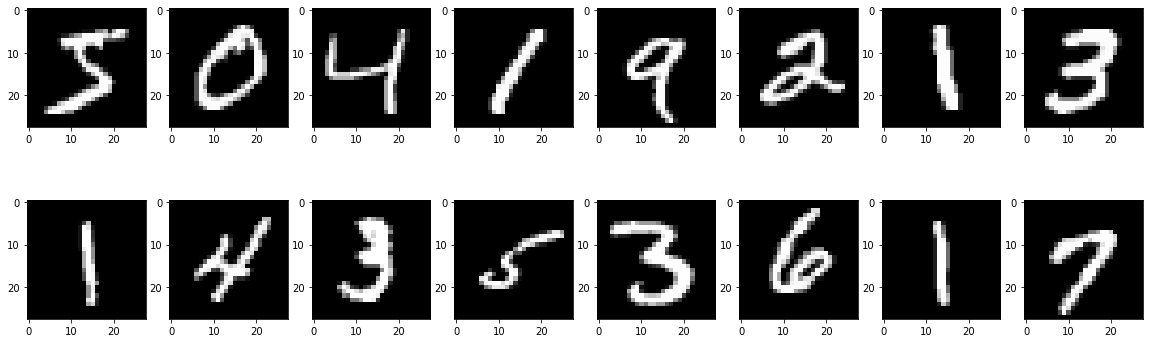

In [36]:
fig = plt.figure(figsize= (20, 10))
for i in range (0,16):
    pixels = X_train[:,i]*255
    pixels = pixels.reshape((28, 28))
    pixels = np.array(pixels, dtype='uint8')    
    # required nrows=4, required ncoms=4, index_location= i+1
    ax = fig.add_subplot(3, 8, i+1)
    # x_batch[i]: Image object at each iteration
    ax.imshow(pixels, cmap='gray')
    
    

### Codificador   
Transforma las etiquetas categóricas (representadas con enteros) a "one-hot-encoding" 

In [37]:
def one_hot(y):
    one_hot_y = np.zeros((y.size, y.max() + 1))
    one_hot_y[np.arange(y.size), y] = 1
    one_hot_y = one_hot_y.T
    return(one_hot_y)

### Función de activación

La red está constituida de dos capas: una capa de salida y una capa oculta. Cada capa está definida por una matriz de pesos $w_i$ para $i=1,2$

Para la "función de activación" $\sigma(x)$ se elige una sigmoide

$\sigma(x)=\frac{1}{1+e^{-x}}$  

In [38]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

La derivada de la función de activación sigmoidal es

$\frac{d\sigma}{dx}=\sigma(x)(1-\sigma(x))$

In [39]:
def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

### Forward propagation o Forward pass

El "forward propagation" o evaluación hacia adelante de la red es el siguiente:

$z_1=w_1x+b_1$ la primera capa recibe $x$, multiplica por la matriz de pesos $w_1$, suma el bias $b_1$ y aplica la función sigmoide para obtener $y_1$ a la salida
$y_1=\sigma(z_1)$   
$z_2=w_2y_1+b_2$  
$y_s=\sigma(z_2)$ la segunda capa recibe $y_1$ multiplica por la matriz de pesos $w_2$, suma el bias $b_2$ y aplica la función sigmoide para obtener $y_s$ a la salida

In [40]:
def forwardprop(w1, b1, w2, b2, x):
    z1 = w1.dot(x) + b1
    y1 = sigmoid(z1)
    z2 = w2.dot(y1) + b2
    ys = sigmoid(z2)
    return z1, y1, z2, ys

### Funciones de costo MSE o logística

In [41]:
# función de costo MSE
# E=(1/len(t))*np.sum((ys-one_hot(t))**2)

# función de costo logística
#T = one_hot(t).T
#E = (-1/100)*np.sum(T*(np.log(ys.T)) + (1-T)*np.log(1-ys.T))

### Backpropagation para las funciones MSE o logística

El "backward propagation" o evaluación hacia atrás, se usa para construir el gradiente con respecto a los pesos $\nabla E_w = (\frac{dE}{dw_1}, \frac{dE}{dw_2})$

En este caso  
$\frac{dE}{dw_2}= \frac{dE}{dy_s}\frac{dy_s}{dw_2}$   
$\frac{dE}{db_2}= \frac{dE}{dy_s}\frac{dy_s}{dw_2}$   
$\frac{dE}{dw_1}= \frac{dE}{dy_s}\frac{dy_s}{dy_1} \frac{dy_1}{dw_1}$     
$\frac{dE}{db_1}= \frac{dE}{dy_s}\frac{dy_s}{dw_2}$   



In [42]:
def backprop_log(y1, z1, ys, z2, w1, w2, x, y):
    m, n = x.shape
    dys = ys - one_hot(y) 
    dw2 = (1/m)*(dys.dot(y1.T))
    db2 = (1/m)*np.sum(dys)
    dz1 = w2.T.dot(dys)*sigmoid_prime(z1)
    dw1 = (1/m)*dz1.dot(x.T)
    db1 = (1/m)*np.sum(dz1)
    return dw2, db2, dw1, db1

In [43]:
def backprop_ls(y1, z1, ys, z2, w1, w2, x, y):
    m, n = x.shape
    dE = (1/m)*(ys - one_hot(y)) #dE=(10x100), sigma(z2)= 10x100, y1=(25x100)
    dw2_ = (dE*sigmoid_prime(z2))
    dw2 = y1.dot(dw2_.T).T #(25x10)
    db2 = np.sum(dw2_,1) #(10x1)
    
    dw1_ = ((dE*sigmoid_prime(z2)).T.dot(w2)*sigmoid_prime(z1).T).T
    dw1 = dw1_.dot(x.T)
    db1 =np.sum(dw1_,1)    
    return dw2, np.reshape(db2,(len(db2),1)), dw1, np.reshape(db1,(len(db1),1))

### Optimización con descenso de gradiente

La función de costo $E(w_1,w_2)$ que la red minimiza está dada por

$E(w_1,w_2)=\sum_{i=1}^N(y_s-t)^2$ donde $y_s=\sigma(w_2\sigma(w_1x+b_1)+b_2)$  

Ya que se tiene el gradiente de $E$, i.e. $\nabla E = (\frac{dE}{dw_1}, \frac{dE}{dw_2}, \frac{dE}{db_1}, \frac{dE}{db_2})$, podemos usar el método de descenso de gradiente para encontrar el mínimo. 

Esto es, construimos una sucesión de valores $w^k$ y $b^k$ para $k=1,2,3, \ldots$ usando la regla  

$w^{k+1}=w^k-\alpha \nabla E(w^k)$ donde $w=(w_1,w_2)$  
$b^{k+1}=b^k-\alpha \nabla E(b^k)$ donde $b=(b_1,b_2)$  


Visto de otra forma  

$w_1^{k+1}=w_1^{k} - \alpha \frac{dE(w^k)}{dw_1}$  
$w_2^{k+1}=w_2^{k} - \alpha \frac{dE(w^k)}{dw_2}$  
$b_1^{k+1}=b_1^{k} - \alpha \frac{dE(b^k)}{db_1}$  
$b_2^{k+1}=b_2^{k} - \alpha \frac{dE(b^k)}{db_2}$  

para $k=1,2,3, \ldots$ 

En optimización, $\alpha$ es conocido como el "paso" en la dirección de búsqueda pero en el contexto de redes neuronales se le conoce como el "learning rate" o tasa de aprendizaje.  
Por otro lado, al método para construir el gradiente usando la regla de la cadena se conoce como "backpropagation".  
Cada iteración $k$ es conocida como épocas

In [44]:
# datos y etiquetas de entrada

x=X_train
t=Y_train

# se inicializan los pesos y bias de forma aleatoria
w1 = np.random.rand(25, 784)-0.5
w2 = np.random.rand(10, 25)-0.5
b1 = np.random.rand(25,1)-0.5
b2 = np.random.rand(10,1)-0.5
        
# se elige el "learning rate"    
alpha=0.4

#se elige el número de épocas
EPOCHS=10000
loss=[]

for i in range(EPOCHS):
    z1, y1, z2, ys = forwardprop(w1, b1, w2, b2, x) #forward pass
    dw2, db2, dw1, db1 = backprop_ls(y1, z1, ys, z2, w1, w2, x, t) #backward pass
    
    # actualizamos pesos y bias con descenso de gradiente
    w2=w2-alpha*dw2
    w1=w1-alpha*dw1
    b2=b2-alpha*db2
    b1=b1-alpha*db1
   
    # función de costo logística
    #T = one_hot(t).T
    #E = (-1/100)*np.sum(T*(np.log(ys.T)) + (1-T)*np.log(1-ys.T))
    
    #función de costo MSE
    E=(1/len(t))*np.sum((ys-one_hot(t))**2)
    
    loss.append(E)
    #print(loss[i])

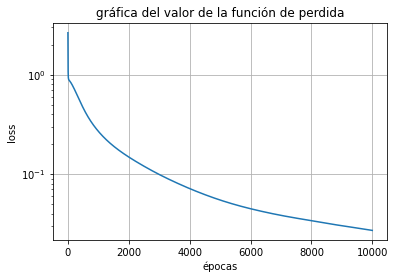

In [45]:
plt.plot(loss)
plt.yscale('log')
plt.title('gráfica del valor de la función de perdida')
plt.xlabel('épocas')
plt.ylabel('loss')
plt.grid()

### Predicción sobre el conjunto de prueba

Una vez que los pesos $w$ han sido calculados (la red ha sido entrenada), para hacer la predicción solo es necesario hacer el forwar pass en un dato nuevo $x$

In [46]:
# la siguiente función calcula la exactitud de la red
def calculateAccuracy(ys, Y):
    m,n = Y.shape
    c=0
    for i in range(n):
        if ((ys[:,i]==Y[:,i]).all()):
            c+=1      
    return (c/n)*100

In [47]:
# X_test, Y_test es el conjunto de 100 datos (que la red nunca ha visto) sobre los que se evaluará la red
z1, y1, z2, ys = forwardprop(w1, b1, w2, b2, X_test)

# como ys es continua es necesario hacer umbralización 
ys[np.where(ys>0.5)]=1
ys[np.where(ys<=0.5)]=0
acc=calculateAccuracy(ys, one_hot(Y_test))
print('Accuracy: %2.2f ' % acc) 

Accuracy: 80.00 


In [53]:
one_hot(Y_test[i])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

### Visualizamos cuales fueron los errores de la red neuronal

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


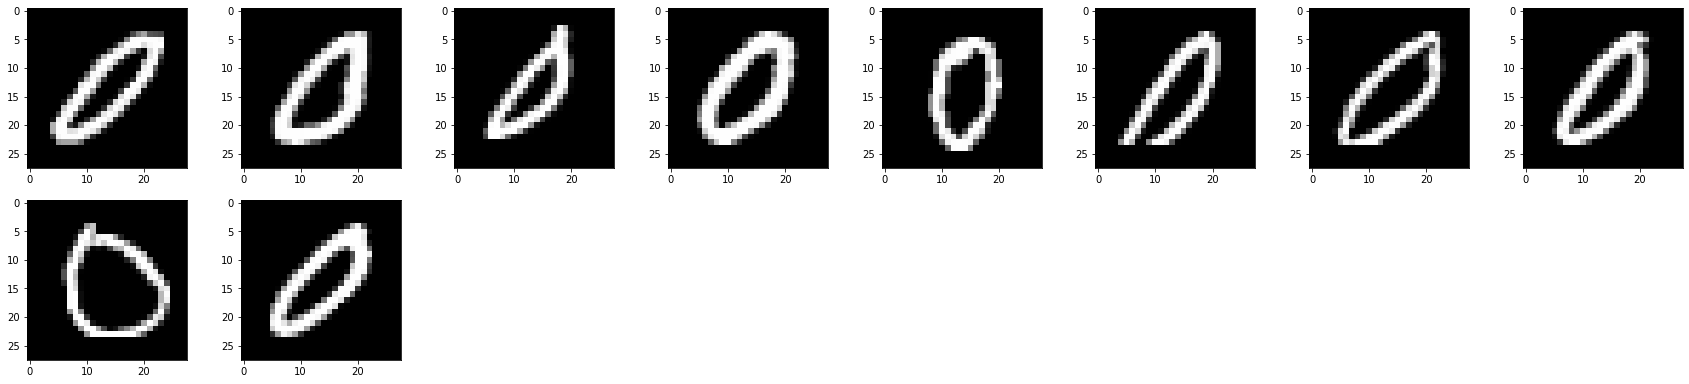

In [73]:
fig = plt.figure(figsize= (30, 10))
c=0
for i in range (0,X_test.shape[1]):
    if one_hot(Y_test[i]).all()!= ys[:,i].all():
        pixels=(X_test[:,i]*255).reshape((28, 28))
        pixels = np.array(pixels, dtype='uint8')    
        ax = fig.add_subplot(3, 8, c+1)
        ax.imshow(pixels, cmap='gray')
        print(ys[:,1])
        c+=1